In [23]:
import pandas as pd
import numpy as np

# Load both the new and old datasets
new_data_path = '/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/PS1_chia.csv'  # Đường dẫn tới file dữ liệu mới
old_data_path = '/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/testthudataa.csv'  # Đường dẫn tới file dữ liệu cũ

# Đọc dữ liệu vào DataFrames
new_data = pd.read_csv(new_data_path)
old_data = pd.read_csv(old_data_path)

# Hàm để tính toán phân vị (percentiles) dựa trên dữ liệu cũ và áp dụng vào dữ liệu mới
def adjust_data_to_distribution(old_data, new_data, feature, bins=10):
    """Chuyển đổi phân phối dữ liệu mới để khớp với phân phối của dữ liệu cũ"""
    # Tính toán các phân vị dựa trên dữ liệu cũ
    percentiles = np.percentile(old_data[feature], np.linspace(0, 100, bins + 1))
    
    # Nhóm dữ liệu mới dựa trên các phân vị của dữ liệu cũ
    new_data_binned = np.digitize(new_data[feature], percentiles, right=True)
    
    # Lấy giá trị trung bình của mỗi phân vị và điều chỉnh dữ liệu mới
    adjusted_values = [old_data[feature].quantile(i / bins) for i in range(bins)]
    
    # Đảm bảo không vượt chỉ số trong adjusted_values
    new_data[feature] = [adjusted_values[min(i-1, bins-1)] for i in new_data_binned]
    
    return new_data

# Lấy danh sách các cột cần điều chỉnh (các cột có trong PSI)
numeric_old_data = old_data.select_dtypes(include=[np.number])
numeric_new_data = new_data.select_dtypes(include=[np.number])
common_numeric_features = list(set(numeric_old_data.columns).intersection(set(numeric_new_data.columns)))

# Áp dụng điều chỉnh cho mỗi cột dựa trên PSI
for feature in common_numeric_features:
    new_data = adjust_data_to_distribution(numeric_old_data, new_data, feature)

# Lưu dữ liệu mới đã được điều chỉnh
new_adjusted_data_path = '/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/new_data_adjusted.csv'
new_data.to_csv(new_adjusted_data_path, index=False)

print(f"Data mới đã được điều chỉnh và lưu tại: {new_adjusted_data_path}")


Data mới đã được điều chỉnh và lưu tại: /Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/new_data_adjusted.csv


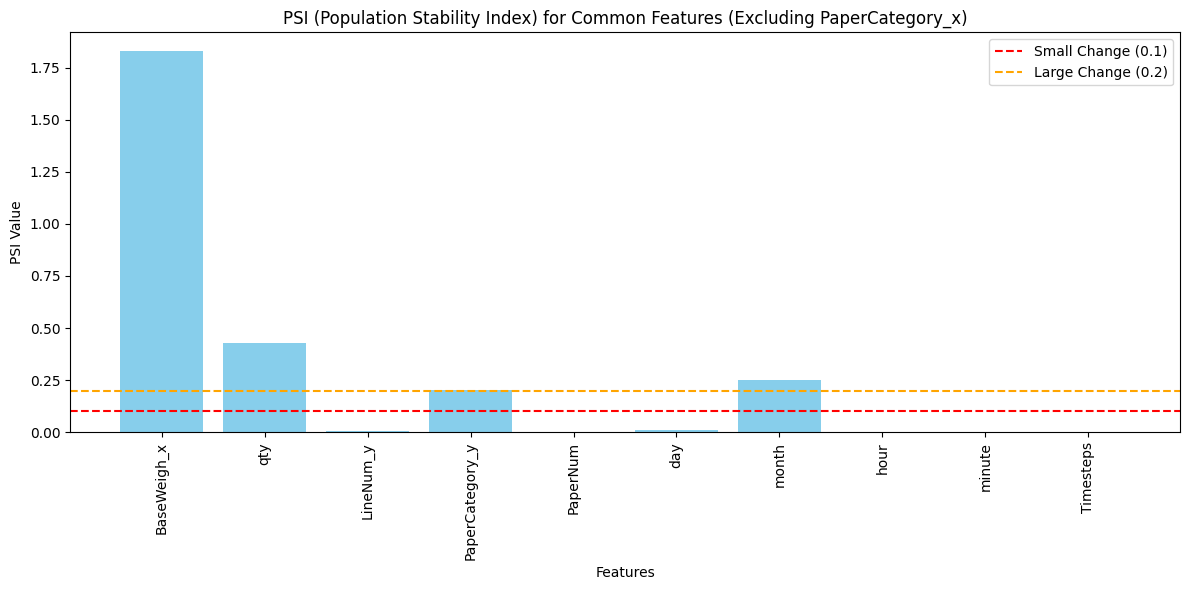

           Feature       PSI
0      BaseWeigh_x  1.827385
1              qty  0.429443
2        LineNum_y  0.007870
3  PaperCategory_y  0.204032
4         PaperNum  0.001230
5              day  0.009943
6            month  0.251710
7             hour  0.000000
8           minute  0.000000
9        Timesteps  0.000000


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate PSI
def calculate_psi(expected, actual, buckets=10):
    # Divide the data into equal-sized bins
    breakpoints = np.linspace(0, 1, buckets + 1)
    
    expected_percents = np.histogram(expected, bins=buckets, range=(expected.min(), expected.max()))[0] / len(expected)
    actual_percents = np.histogram(actual, bins=buckets, range=(expected.min(), expected.max()))[0] / len(actual)
    
    # Avoid division by zero
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    
    # Calculate PSI values
    psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    
    return np.sum(psi_values)

# Load your datasets
new_data = pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/PS1_chia.csv')
old_data = pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/testthudataa.csv')

# Define the features for comparison
pm_features = ['PM1_1', 'PM1_2', 'PM1_3', 'PM1_4', 'PM1_5', 'PM1_6', 'PM1_7', 'PM1_f', 'PaperCategory_x',
               'BaseWeigh_x', 'qty', 'LineNum_y', 'PaperCategory_y', 'PaperNum', 'day', 'month', 'hour', 'minute', 'weekday', 'Timesteps']

# Finding the common columns between the two datasets
common_columns = set(new_data.columns).intersection(set(old_data.columns))

# Filter only those from pm_features that are common in both datasets
common_pm_features = [col for col in pm_features if col in common_columns]

# Convert the data to numeric, forcing errors to NaN and then fill or drop those values.
new_data_clean = new_data[common_pm_features].apply(pd.to_numeric, errors='coerce')
old_data_clean = old_data[common_pm_features].apply(pd.to_numeric, errors='coerce')

# Filling missing values with the mean of the respective columns for simplicity (you can choose other methods if necessary)
new_data_clean.fillna(new_data_clean.mean(), inplace=True)
old_data_clean.fillna(old_data_clean.mean(), inplace=True)

# Remove the problematic column 'PaperCategory_x' from both datasets due to too many NaNs
if 'PaperCategory_x' in new_data_clean.columns and 'PaperCategory_x' in old_data_clean.columns:
    new_data_clean = new_data_clean.drop(columns=['PaperCategory_x'])
    old_data_clean = old_data_clean.drop(columns=['PaperCategory_x'])

# Recalculate PSI after cleaning and dropping problematic columns
psi_results = {}
for column in new_data_clean.columns:
    psi_value = calculate_psi(old_data_clean[column], new_data_clean[column])
    psi_results[column] = psi_value

# Convert PSI results to DataFrame
psi_df = pd.DataFrame(list(psi_results.items()), columns=['Feature', 'PSI'])

# Visualize the PSI results
plt.figure(figsize=(12, 6))
plt.bar(psi_df['Feature'], psi_df['PSI'], color='skyblue')
plt.title('PSI (Population Stability Index) for Common Features (Excluding PaperCategory_x)')
plt.ylabel('PSI Value')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.axhline(0.1, color='red', linestyle='--', label='Small Change (0.1)')
plt.axhline(0.2, color='orange', linestyle='--', label='Large Change (0.2)')
plt.legend()
plt.tight_layout()
plt.show()

# Print out PSI results
print(psi_df)


In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Read data and prepare
# data = pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/testthudataa.csv')
data=pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/PS1_chia.csv')

data = data.sort_values(by='Time')

# Convert 'Time' column to datetime if not already in the correct format
data['Time'] = pd.to_datetime(data['Time'])

# Add 'year', 'day', and 'month' columns from 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# # Define features
# encoder_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
#                     'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
#                     'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month',
#                     'hour', 'minute']
# pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
#                'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute', 'PM_s1']
# pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
#                      'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute', 'PM_lw1']
# y = data[['PM', 'PM_steam']].values
# Định nghĩa các đặc trưng
encoder_features = ['PM1_1','S1_1', 'PM1_2','S1_2','PM1_3','S1_3','PM1_4','S1_4',
                   'PM1_5', 'S1_5', 'PM1_6','S1_6','PM1_7','S1_7','PM1_f','PaperCategory_x','BaseWeigh_x','qty','LineNum_y',
                   'PaperCategory_y','PaperNum', 'day', 'month', 'hour', 'minute','weekday','Timesteps'
                    ]
pm_features = ['PM1_1', 'PM1_2', 'PM1_3', 'PM1_4', 'PM1_5', 'PM1_6', 'PM1_7','PM1_f','PaperCategory_x',
               'BaseWeigh_x','qty','LineNum_y',
                   'PaperCategory_y','PaperNum', 'day', 'month', 'hour', 'minute','weekday','Timesteps']
pm_steam_features = ['S1_1', 'S1_2', 'S1_3', 'S1_4', 'S1_5', 'S1_6', 'S1_7','PM1_f','PaperCategory_x',
               'BaseWeigh_x','qty','LineNum_y',
                   'PaperCategory_y','PaperNum', 'day', 'month', 'hour', 'minute','weekday','Timesteps']
y = data[['PM1', 'FIL301']].values
# Standardize data
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)

# Convert to tensors
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split data into training and testing
total_samples = len(data)
train_percentage = 0.9
test_percentage = 0.1

# Calculate train and test sizes
train_size = int(total_samples * train_percentage)
test_size = total_samples - train_size

# Adjust train size to be divisible by 288
train_size -= train_size % 288
test_size = total_samples - train_size

# Split data into train and test sets
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Check and filter days with 288 points in the train set
daily_counts_train = train_data.groupby(['year', 'month', 'day']).size()
complete_days_train = daily_counts_train[daily_counts_train == 288].index

# Filter train data to include only days with 288 points
train_data = train_data[train_data.set_index(['year', 'month', 'day']).index.isin(complete_days_train)]

# Prepare training features and labels
X_encoder_train = scaler_encoder.fit_transform(train_data[encoder_features])
X_pm_train = scaler_pm.fit_transform(train_data[pm_features])
X_pm_steam_train = scaler_pm_steam.fit_transform(train_data[pm_steam_features])
y_train = scaler_y.fit_transform(train_data[['PM1', 'FIL301']])

# Convert to tensors
X_encoder_train = torch.tensor(X_encoder_train, dtype=torch.float32)
X_pm_train = torch.tensor(X_pm_train, dtype=torch.float32)
X_pm_steam_train = torch.tensor(X_pm_steam_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

Có nhiều hơn một hàng phù hợp: Index([51264, 51265, 51266, 51267, 51268, 51269, 51270, 51271, 51272, 51273,
       ...
       51542, 51543, 51544, 51545, 51546, 51547, 51548, 51549, 51550, 51551],
      dtype='int64', length=288)


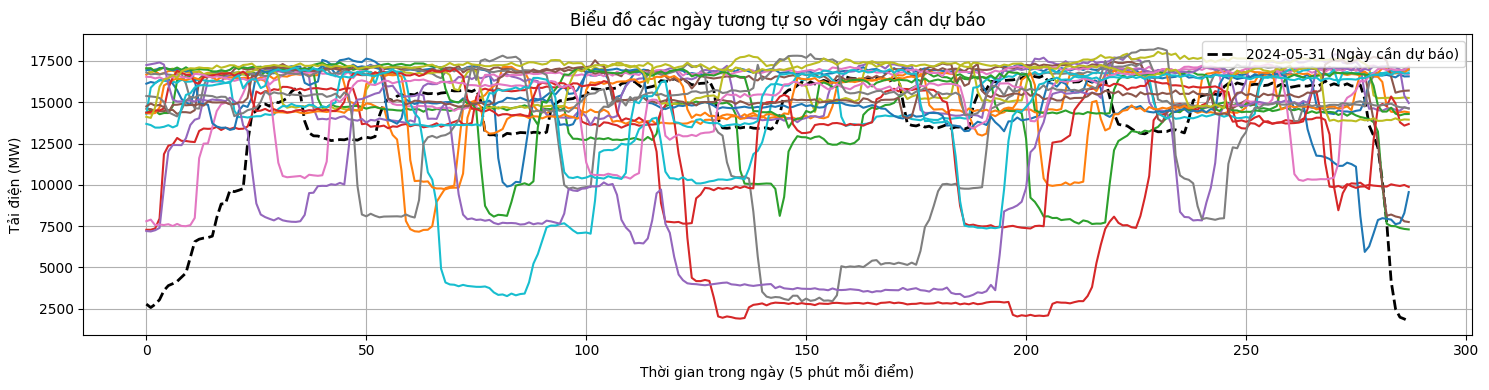

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import random

# Đặt seed để đảm bảo tính tái lập của kết quả
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc dữ liệu và chuẩn bị
data = pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/testthudataa.csv')
data=pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/PS1_chia.csv')

data = data.sort_values(by='Time')

# Chuyển cột 'Time' thành datetime nếu chưa đúng định dạng
data['Time'] = pd.to_datetime(data['Time'])

# Thêm các cột 'year', 'day', và 'month' từ 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# Định nghĩa các đặc trưng cần thiết
target_features = [  'PM1_f']

# Chuẩn hóa dữ liệu
scaler_target = StandardScaler()
X_target = scaler_target.fit_transform(data[target_features])

# Chuyển đổi sang tensor
X_target = torch.tensor(X_target, dtype=torch.float32)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
total_samples = len(data)
train_percentage = 0.9

# Xác định kích thước tập huấn luyện và kiểm tra
train_size = int(total_samples * train_percentage)
test_size = total_samples - train_size

# Điều chỉnh kích thước tập huấn luyện để chia hết cho 288
train_size -= train_size % 288
test_size = total_samples - train_size

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Kiểm tra và lọc các ngày có đủ 288 điểm trong tập huấn luyện
daily_counts_train = train_data.groupby(['year', 'month', 'day']).size()
complete_days_train = daily_counts_train[daily_counts_train == 288].index

# Lọc dữ liệu huấn luyện để chỉ bao gồm các ngày có đủ 288 điểm
train_data = train_data[train_data.set_index(['year', 'month', 'day']).index.isin(complete_days_train)]

# Chuẩn bị các đặc trưng huấn luyện và nhãn
X_target_train = scaler_target.fit_transform(train_data[target_features])
X_target_train = torch.tensor(X_target_train, dtype=torch.float32)

# Xác định ngày mục tiêu
target_day = 31
target_month = 5
target_year = 2024

# Tìm các hàng trong tập kiểm tra cho ngày mục tiêu
target_indices = test_data[(test_data['day'] == target_day) & 
                           (test_data['month'] == target_month) & 
                           (test_data['year'] == target_year)].index

# Kiểm tra nếu có nhiều hơn một hàng phù hợp, chọn chỉ số phù hợp
if len(target_indices) > 1:
    print(f"Có nhiều hơn một hàng phù hợp: {target_indices}")

# Lấy dữ liệu ngày mục tiêu từ tập kiểm tra
target_day_data = X_target_train[target_indices[0] % 288].numpy()  # Lấy 288 điểm cho ngày mục tiêu

# Trích xuất các chỉ số của mỗi ngày trong tập huấn luyện
daily_indices_train = [train_data[(train_data['year'] == y) & 
                                  (train_data['month'] == m) & 
                                  (train_data['day'] == d)].index 
                       for y, m, d in complete_days_train]

# Hàm tính khoảng cách Manhattan cho tất cả 288 điểm của mỗi ngày
def calculate_daily_manhattan_distance(target_day_data, historical_data, daily_indices):
    daily_distances = []
    for indices in daily_indices:
        day_data = historical_data[indices]  # Lấy dữ liệu cho ngày hiện tại (288 điểm)
        distance = np.sum(np.abs(day_data - target_day_data))  # Tính khoảng cách Manhattan
        daily_distances.append(distance)
    
    return np.array(daily_distances)

# Tính khoảng cách Manhattan giữa ngày mục tiêu và tất cả các ngày trong tập huấn luyện
distances = calculate_daily_manhattan_distance(target_day_data, X_target_train.numpy(), daily_indices_train)
n =20
# Sắp xếp và chọn ra các ngày tương tự nhất từ tập huấn luyện
sorted_indices = np.argsort(distances)
top_similar_days = [complete_days_train[idx] for idx in sorted_indices[:n]]  # Chọn ra 100 ngày tương tự nhất

# Sắp xếp các ngày tương tự theo thứ tự thời gian
top_similar_days_sorted = sorted(top_similar_days, key=lambda x: (x[0], x[1], x[2]))

# Chuẩn bị dữ liệu của ngày cần dự báo
target_day_label = f'{target_year}-{target_month:02d}-{target_day:02d}'
target_day_load_values = test_data.loc[target_indices, 'PM1'].values  # Điều chỉnh tên cột nếu cần thiết

# Vẽ biểu đồ các ngày tương tự
def plot_similar_days(train_data, similar_days, target_day_data, target_day_label):
    plt.figure(figsize=(15, 4))
    
    # Vẽ dữ liệu của ngày cần dự báo
    plt.plot(range(288), target_day_data, label=f'{target_day_label} (Ngày cần dự báo)', linewidth=2, linestyle='--', color='black')
    
    # Vẽ dữ liệu của các ngày tương tự
    for day in similar_days:
        day_data = train_data[(train_data['year'] == day[0]) & 
                              (train_data['month'] == day[1]) & 
                              (train_data['day'] == day[2])]
        load_values = day_data['PM1'].values  # Điều chỉnh tên cột nếu cần thiết
        # label = f'{day[0]}-{day[1]:02d}-{day[2]:02d}'  # Định dạng ngày tháng năm
        
        plt.plot(range(288), load_values)
        # plt.plot(range(288), load_values, label=label)

    plt.title('Biểu đồ các ngày tương tự so với ngày cần dự báo')
    plt.xlabel('Thời gian trong ngày (5 phút mỗi điểm)')
    plt.ylabel('Tải điện (MW)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ các ngày tương tự
plot_similar_days(train_data, top_similar_days_sorted[:n], target_day_load_values, target_day_label)

# Chuẩn bị dữ liệu cho mô hình từ các ngày tương tự
similar_day_indices = []

for day in top_similar_days_sorted:
    indices = train_data[(train_data['year'] == day[0]) & 
                         (train_data['month'] == day[1]) & 
                         (train_data['day'] == day[2])].index
    similar_day_indices.extend(indices)

# Giả sử có các đặc trưng X_encoder, X_pm, X_pm_steam và nhãn y cho huấn luyện
X_encoder_train = X_encoder[similar_day_indices]
X_pm_train = X_pm[similar_day_indices]
X_pm_steam_train = X_pm_steam[similar_day_indices]
y_train = y[similar_day_indices]

# Tạo TensorDataset cho tập train với các ngày tương tự
train_dataset = TensorDataset(X_encoder_train, X_pm_train, X_pm_steam_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [17]:
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Định nghĩa lớp Encoder cho mô hình Transformer
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Định nghĩa lớp Decoder cho mô hình Transformer
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output là một scalar cho mỗi thời điểm

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Định nghĩa mô hình MultiDeT với hai Decoder cho hai loại tải
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình Transformer (MultiDeT)
model = MultiDeT(encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2)

# Định nghĩa hàm loss và optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

# Hàm huấn luyện mô hình
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
        scheduler.step(epoch_loss)

    return train_losses

# Huấn luyện mô hình với tập dữ liệu từ các ngày tương tự
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)


# Tạo tập test cho đánh giá
test_day = 31
test_month = 5
test_year = 2024

# Tìm chỉ số của ngày cần dự báo trong tập test
test_indices = test_data[(test_data['day'] == test_day) & 
                         (test_data['month'] == test_month) & 
                         (test_data['year'] == test_year)].index

# Đảm bảo có đủ 288 điểm dữ liệu cho ngày này
if len(test_indices) == 288:
    print(f"Dự báo cho ngày {test_day}/{test_month}/{test_year}")

    X_encoder_test = X_encoder[test_indices]
    X_pm_test = X_pm[test_indices]
    X_pm_steam_test = X_pm_steam[test_indices]
    y_test = y[test_indices]

    test_dataset = TensorDataset(X_encoder_test, X_pm_test, X_pm_steam_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Đánh giá mô hình
    def evaluate_model(model, test_loader, criterion, scaler_y):
        model.eval()
        test_loss = 0.0
        true_values_pm = []
        true_values_pm_steam = []
        predicted_values_pm = []
        predicted_values_pm_steam = []

        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in test_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                output1 = output1.view(-1)
                output2 = output2.view(-1)

                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])
                loss = 0.8 * loss1 + 0.2 * loss2
                test_loss += loss.item() * X_enc.size(0)

                true_values_pm.extend(y[:, 0].cpu().numpy())
                true_values_pm_steam.extend(y[:, 1].cpu().numpy())
                predicted_values_pm.extend(output1.cpu().numpy())
                predicted_values_pm_steam.extend(output2.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}')

        true_values_pm = np.array(true_values_pm)
        true_values_pm_steam = np.array(true_values_pm_steam)
        predicted_values_pm = np.array(predicted_values_pm)
        predicted_values_pm_steam = np.array(predicted_values_pm_steam)

        true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
        predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

        true_values_pm = true_values[:, 0]
        true_values_pm_steam = true_values[:, 1]
        predicted_values_pm = predicted_values[:, 0]
        predicted_values_pm_steam = predicted_values[:, 1]

        mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
        mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

        print(f'MAPE for PM: {mape_pm:.2f}%')
        print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

        return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

    # Đánh giá mô hình với tập test
    true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

    # Vẽ biểu đồ dự báo và giá trị thực cho PM
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm, label='True PM')
    plt.plot(predicted_values_pm, label='Predicted PM')
    plt.xlabel('Time (5-min interval)')
    plt.ylabel('PM (W)')
    plt.title(f'Dự báo PM cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm_steam, label='True PM_steam')
    plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
    plt.xlabel('Time (5-min interval)')
    plt.ylabel('PM_steam (ton/h)')
    plt.title(f'Dự báo PM_steam cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()
else:
    print(f"Không đủ 288 điểm dữ liệu cho ngày {test_day}/{test_month}/{test_year}")

NameError: name 'nn' is not defined

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Read data and prepare
data = pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/PS1_chia.csv')
old_data = pd.read_csv('/Users/nguyendinhhuy/Documents/NCKU/2309 - 1628/testthudataa.csv')

data = data.sort_values(by='Time')

# Convert 'Time' column to datetime if not already in the correct format
data['Time'] = pd.to_datetime(data['Time'])

# Add 'year', 'day', and 'month' columns from 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# Define features
encoder_features = ['PM1_1', 'S1_1', 'PM1_2', 'S1_2', 'PM1_3', 'S1_3', 'PM1_4', 'S1_4',
                    'PM1_5', 'S1_5', 'PM1_6', 'S1_6', 'PM1_7', 'S1_7', 'PM1_f', 'PaperCategory_x', 
                    'BaseWeigh_x', 'qty', 'LineNum_y', 'PaperCategory_y', 'PaperNum', 'day', 
                    'month', 'hour', 'minute', 'weekday', 'Timesteps']

# Ensure that all columns are numeric by coercing to numbers and filling NaNs
def clean_data(df, features):
    df_clean = df.copy()
    for feature in features:
        # Coerce the column to numeric and replace NaN values with the column mean
        df_clean[feature] = pd.to_numeric(df_clean[feature], errors='coerce')
        df_clean[feature].fillna(df_clean[feature].mean(), inplace=True)
    return df_clean

# Clean both old and new data for the selected features
data_clean = clean_data(data, encoder_features)
old_data_clean = clean_data(old_data, encoder_features)

# 1. Calculate PSI function
def calculate_psi(expected, actual, buckets=10):
    breakpoints = np.linspace(0, 1, buckets + 1)
    expected_percents = np.histogram(expected, bins=buckets, range=(expected.min(), expected.max()))[0] / len(expected)
    actual_percents = np.histogram(actual, bins=buckets, range=(expected.min(), expected.max()))[0] / len(actual)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    return np.sum(psi_values)

# 2. Calculate PSI for all features
def calculate_psi_for_all_features(old_data, new_data, features):
    psi_results = {}
    for column in features:
        if column in old_data.columns and column in new_data.columns:
            psi_value = calculate_psi(old_data[column], new_data[column])
            psi_results[column] = psi_value
    return psi_results

# Calculate PSI with cleaned data
psi_results = calculate_psi_for_all_features(old_data_clean, data_clean, encoder_features)

# 3. Reweighting based on PSI
def apply_psi_weighting(data_new, psi_results):
    weights = {}
    for column in psi_results:
        psi_value = psi_results[column]
        weights[column] = 1 / (1 + psi_value)  # Apply weight based on PSI

    # Adjust each feature in data_new based on its weight
    weighted_data_new = data_new.copy()
    for column in weights:
        if column in weighted_data_new.columns:
            weighted_data_new[column] *= weights[column]
    
    return weighted_data_new

# Apply weighting to the cleaned data
weighted_data = apply_psi_weighting(data_clean, psi_results)

# Standardize data
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(weighted_data[encoder_features])
X_pm = scaler_pm.fit_transform(weighted_data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(weighted_data[pm_steam_features])
y = scaler_y.fit_transform(data_clean[['PM1', 'FIL301']].values)

# Convert to tensors
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split data into training and testing
total_samples = len(data)
train_percentage = 0.9

train_size = int(total_samples * train_percentage)
test_size = total_samples - train_size

# Adjust train size to be divisible by 288
train_size -= train_size % 288
test_size = total_samples - train_size

# Split data into train and test sets
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Prepare training features and labels
X_encoder_train = scaler_encoder.fit_transform(train_data[encoder_features])
X_pm_train = scaler_pm.fit_transform(train_data[pm_features])
X_pm_steam_train = scaler_pm_steam.fit_transform(train_data[pm_steam_features])
y_train = scaler_y.fit_transform(train_data[['PM1', 'FIL301']])

# Convert to tensors
X_encoder_train = torch.tensor(X_encoder_train, dtype=torch.float32)
X_pm_train = torch.tensor(X_pm_train, dtype=torch.float32)
X_pm_steam_train = torch.tensor(X_pm_steam_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Create a DataLoader for training
train_dataset = TensorDataset(X_encoder_train, X_pm_train, X_pm_steam_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Define the MultiDeT model with two decoders
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))
        
        # Decode both PM and PM_steam
        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Initialize the model
model = MultiDeT(encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

# Training loop function
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])  # PM loss
            loss2 = criterion(output2, y[:, 1])  # PM_steam loss

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2  # Weighted loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
        scheduler.step(epoch_loss)

    return train_losses

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

# Model evaluation function
def evaluate_model(model, X_encoder, X_pm, X_pm_steam, y, scaler_y):
    model.eval()
    with torch.no_grad():
        output1, output2 = model(X_encoder, X_pm, X_pm_steam)

        # Reshape outputs
        output1 = output1.view(-1)
        output2 = output2.view(-1)

        # Inverse scaling for true and predicted values
        true_values = scaler_y.inverse_transform(y.numpy())
        predicted_values_pm = scaler_y.inverse_transform(output1.numpy().reshape(-1, 1))
        predicted_values_pm_steam = scaler_y.inverse_transform(output2.numpy().reshape(-1, 1))

        # Calculate evaluation metrics (e.g., MAPE)
        mape_pm = np.mean(np.abs((true_values[:, 0] - predicted_values_pm[:, 0]) / true_values[:, 0])) * 100
        mape_pm_steam = np.mean(np.abs((true_values[:, 1] - predicted_values_pm_steam[:, 0]) / true_values[:, 1])) * 100

        print(f'MAPE for PM: {mape_pm:.2f}%')
        print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

        return predicted_values_pm, predicted_values_pm_steam

# Create test data tensors (for a particular day or time range in your test set)
X_encoder_test = torch.tensor(scaler_encoder.transform(test_data[encoder_features]), dtype=torch.float32)
X_pm_test = torch.tensor(scaler_pm.transform(test_data[pm_features]), dtype=torch.float32)
X_pm_steam_test = torch.tensor(scaler_pm_steam.transform(test_data[pm_steam_features]), dtype=torch.float32)
y_test = torch.tensor(scaler_y.transform(test_data[['PM1', 'FIL301']]), dtype=torch.float32)

# Evaluate the model
predicted_pm, predicted_pm_steam = evaluate_model(model, X_encoder_test, X_pm_test, X_pm_steam_test, y_test, scaler_y)

# Plotting the results
def plot_predictions(true_values, predicted_values, title):
    plt.figure(figsize=(15, 4))
    plt.plot(true_values, label='True Values')
    plt.plot(predicted_values, label='Predicted Values')
    plt.title(title)
    plt.xlabel('Time (5-min intervals)')
    plt.ylabel('Load')
    plt.legend()
    plt.show()

# Plot PM predictions
true_values_pm = scaler_y.inverse_transform(y_test.numpy())[:, 0]
plot_predictions(true_values_pm, predicted_pm[:, 0], 'Predicted vs True PM')

# Plot PM_steam predictions
true_values_pm_steam = scaler_y.inverse_transform(y_test.numpy())[:, 1]
plot_predictions(true_values_pm_steam, predicted_pm_steam[:, 0], 'Predicted vs True PM_steam')



/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_3248/3940159766.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[feature].fillna(df_clean[feature].mean(), inplace=True)


KeyError: 'PM1_1'